In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss

# Load Data

In [2]:

train_df = pd.read_csv(r"C:\IIT\NLP Project\Train.csv")
test_df = pd.read_csv(r"C:\IIT\NLP Project\Test.csv")

# Text cleaning

In [3]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text.strip()

train_df["clean_content"] = train_df["content"].apply(clean_text)
test_df["clean_content"] = test_df["content"].apply(clean_text)

# Encode labels

In [4]:

label_encoder = LabelEncoder()
train_df["category_encoded"] = label_encoder.fit_transform(train_df["category"])
num_classes = len(label_encoder.classes_)

In [19]:
train_df

,id,content,category,clean_content,category_encoded
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa,serikali imesema haitakuwa tayari kuona amani ...,3
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara,mkuu wa mkoa wa tabora aggrey mwanri amesitish...,0
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa,serikali imetoa miezi sita kwa taasisi zote za...,3
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo,kampuni ya mchezo wa kubahatisha ya mbet imein...,4
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa,watanzania wamekumbushwa kusherehekea sikukuu ...,3
...,...,...,...,...,...
5146,SW993,RAIS John Magufuli ameendelea kung’ara katika...,Kitaifa,rais john magufuli ameendelea kungara katika s...,3
5147,SW994,KAMPENI inayohimiza watafi ti kuandika upya h...,Kitaifa,kampeni inayohimiza watafi ti kuandika upya hi...,3
5148,SW996,"MATUKIO mapya ya malaria kwa kila watu 1,000 ...",Kitaifa,matukio mapya ya malaria kwa kila watu katika...,3
5149,SW997,IMEELEZWA kuwa hakuna sheria yoyote inayokata...,Kitaifa,imeelezwa kuwa hakuna sheria yoyote inayokataz...,3


In [20]:
test_df

,swahili_id,content,clean_content
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,"MKUU wa Wilaya ya Bahi, Mkoani Dodoma, Mwanah...",mkuu wa wilaya ya bahi mkoani dodoma mwanahami...
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,"MWISHONI mwa wiki hii, Timu ya Soka ya Taifa,...",mwishoni mwa wiki hii timu ya soka ya taifa ta...
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,THAMANI ya mauzo ya bidhaa za Afrika Masharik...,thamani ya mauzo ya bidhaa za afrika mashariki...
3,00868eeee349e286303706ef0ffd851f39708d37,MENEJA Mawasiliano na Utetezi wa asasi ya AGP...,meneja mawasiliano na utetezi wa asasi ya agpa...
4,00a5cb12d3058dcf2e42f277eee599992db32412,"WAZIRI wa Kilimo, Japhet Hasunga amesema seri...",waziri wa kilimo japhet hasunga amesema serika...
...,...,...,...
1283,feb4b0ae88524c9cee3e50f2301d84a235f3c607,MKURUGENZI Msaidizi Msajili wa Asasi za kirai...,mkurugenzi msaidizi msajili wa asasi za kirai ...
1284,fecf3f14f47237e02721ed4baa4eb6c11abd239f,Kilomoni alisema jana kesho atazungumzia sual...,kilomoni alisema jana kesho atazungumzia suala...
1285,feed09e13586d12139cd59bc20996a4d29706606,"TIMU ya taifa ya soka ya Tanzania Bara, Kilim...",timu ya taifa ya soka ya tanzania bara kiliman...
1286,ffc0bca6fde8fa0cce1ac3a7b0d746603d441bf8,"YANGA imetozwa faini ya Sh 3,500,000 kutokana...",yanga imetozwa faini ya sh kutokana na makosa...


### Tokenization and Padding

In this section, we preprocess the text data using tokenization and padding to prepare it for input into deep learning models.

1. **Tokenization**  
   - We define a `Tokenizer` with a maximum vocabulary size of `10,000` words and an out-of-vocabulary (OOV) token `<OOV>`.  
   - The tokenizer is then fitted on the `clean_content` column of `train_df`, which contains preprocessed Swahili news articles.  
   - The text data is converted into sequences of integers, where each unique word is assigned a numerical index.

2. **Padding Sequences**  
   - Since neural networks require inputs of uniform length, we use `pad_sequences` to ensure all sequences are of length `200`.  
   - Shorter sequences are padded with zeros at the end (`post` padding).

3. **Label Encoding**  
   - The categorical labels in `train_df["category_encoded"]` are converted into one-hot encoded vectors using `tf.keras.utils.to_categorical()`, ensuring that each label is represented as a binary vector.

4. **Splitting Data**  
   - The processed data (`X_padded` and `y`) is split into training and validation sets using `train_test_split()`.  
   - We use an 80-20 split (`test_size=0.2`), ensuring class distribution is maintained (`stratify=y`).  
   - A fixed `random_state=42` ensures reproducibility.

This preprocessing step is crucial for feeding structured numerical data into deep learning models.


In [5]:
# Tokenization and padding
max_vocab_size = 10000
max_sequence_length = 200
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_content"])

X = tokenizer.texts_to_sequences(train_df["clean_content"])
X_padded = pad_sequences(X, maxlen=max_sequence_length, padding="post")
y = tf.keras.utils.to_categorical(train_df["category_encoded"], num_classes)

X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, stratify=y, random_state=42)

### Defining LSTM and CNN Models

This section defines two deep learning models: an LSTM-based model and a CNN-based model for Swahili news classification.

1. **LSTM Model (`build_lstm`)**  
   - The model starts with an **Embedding layer** that converts tokenized words into dense vector representations of size `128`.  
   - A **LSTM (Long Short-Term Memory) layer** with 64 units processes the sequential data, capturing long-range dependencies in text.  
   - A **Dense output layer** with a softmax activation function is used to classify the text into `num_classes` categories.  
   - The model is compiled with the Adam optimizer and categorical cross-entropy loss.

2. **CNN Model (`build_cnn`)**  
   - The CNN model also begins with an **Embedding layer** to represent words as dense vectors.  
   - A **1D Convolutional layer** with 64 filters and a kernel size of 5 is used to extract local features from text.  
   - A **Global Max Pooling layer** reduces dimensionality by selecting the most important features.  
   - A **Dense output layer** with a softmax activation function classifies the text into `num_classes`.  
   - The model is compiled similarly using the Adam optimizer and categorical cross-entropy loss.

Both models aim to classify Swahili news articles into their respective categories based on textual content.


In [6]:
# Define models
def build_lstm():
    model = Sequential([
        Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_sequence_length),
        LSTM(64, return_sequences=False),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_cnn():
    model = Sequential([
        Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_sequence_length),
        Conv1D(64, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train models

In [7]:

lstm_model = build_lstm()
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=7, batch_size=32)


Epoch 1/7


C:\Users\shash\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.4212 - loss: 1.2649 - val_accuracy: 0.4559 - val_loss: 1.0880
Epoch 2/7
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6309 - loss: 0.8922 - val_accuracy: 0.4384 - val_loss: 1.1133
Epoch 3/7
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5689 - loss: 0.9971 - val_accuracy: 0.6372 - val_loss: 0.9279
Epoch 4/7
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7530 - loss: 0.6919 - val_accuracy: 0.7449 - val_loss: 0.7320
Epoch 5/7
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8530 - loss: 0.4652 - val_accuracy: 0.7449 - val_loss: 0.6863
Epoch 6/7
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8581 - loss: 0.4130 - val_accuracy: 0.7517 - val_loss: 0.7850
Epoch 7/7
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9045 - loss: 0.3091 - val_accuracy: 0.7371 - val_loss: 0.8624


In [8]:
cnn_model = build_cnn()
cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4906 - loss: 1.2066 - val_accuracy: 0.6974 - val_loss: 0.6480
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7942 - loss: 0.5293 - val_accuracy: 0.8225 - val_loss: 0.4771
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8926 - loss: 0.3396 - val_accuracy: 0.8371 - val_loss: 0.4355
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9479 - loss: 0.2006 - val_accuracy: 0.8409 - val_loss: 0.4267
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9764 - loss: 0.1067 - val_accuracy: 0.8429 - val_loss: 0.4329


In [9]:
# Evaluate models
y_val_pred_lstm = lstm_model.predict(X_val)
y_val_pred_cnn = cnn_model.predict(X_val)


print("LSTM Log Loss:", log_loss(y_val, y_val_pred_lstm))
print("CNN Log Loss:", log_loss(y_val, y_val_pred_cnn))


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM Log Loss: 0.8623548098699981
CNN Log Loss: 0.43294506302826746


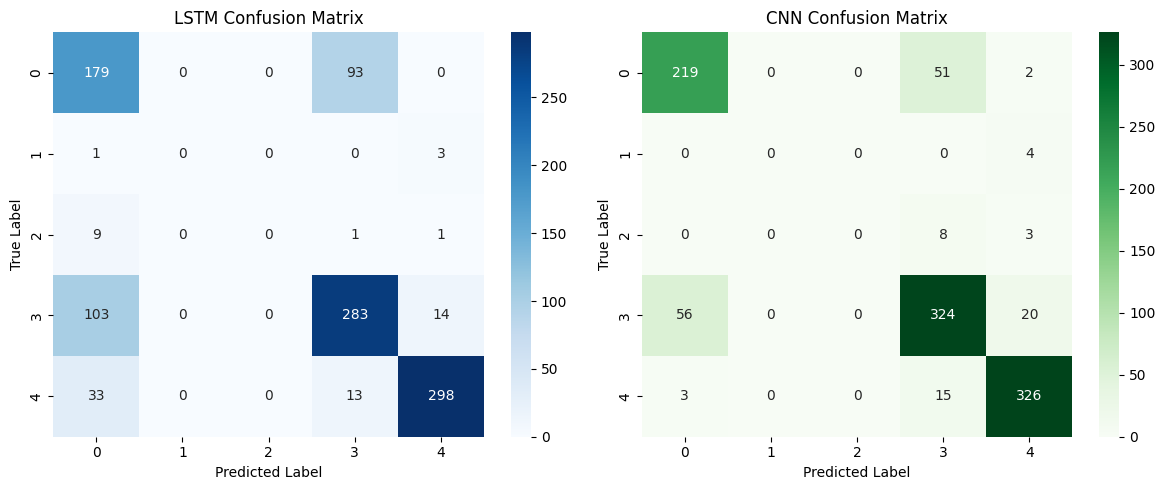

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert predicted probabilities to class labels
y_val_true = y_val.argmax(axis=1)  # Convert one-hot encoded labels to integers
y_val_pred_lstm_labels = y_val_pred_lstm.argmax(axis=1)
y_val_pred_cnn_labels = y_val_pred_cnn.argmax(axis=1)

# Compute confusion matrices
conf_matrix_lstm = confusion_matrix(y_val_true, y_val_pred_lstm_labels)
conf_matrix_cnn = confusion_matrix(y_val_true, y_val_pred_cnn_labels)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(conf_matrix_lstm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("LSTM Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("CNN Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

## Note:
One thing to note here is that the test dataset provided doesnt have the final classification labels, hence it renders the dataset useless as we dont cant test the performance on it without the true labels.